In [1]:
import math
import skimage
from skimage import filters
from skimage.morphology import disk
from skimage.util import img_as_ubyte
import os
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import cv2

In [236]:
os.chdir("/Users/jocelyn/Desktop/semester4/cv_project/1/")

In [92]:
#Data set 1
seeds = plt.imread("A - 10(fld 3 wv DAPI - DAPI).tif")
image = plt.imread("A - 10(fld 3 wv TexasRed - TexasRed).tif")
image_true = plt.imread("A - 10(fld 3 wv TexasRed - TexasRed)_mask.gif")

In [234]:
#Data set 2
seeds = plt.imread("C - 12(fld 10 wv DAPI - DAPI).tif")
image = plt.imread("C - 12(fld 10 wv TexasRed - TexasRed).tif")
image_true = plt.imread("C - 12(fld 10 wv TexasRed - TexasRed)_mask.gif")

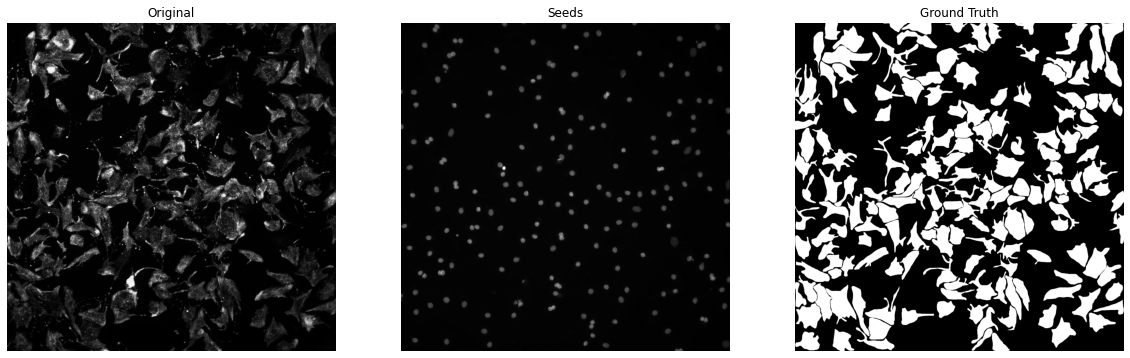

In [229]:
fig = plt.subplots(figsize = (20,20))

plt.subplot(131)
plt.imshow(image, cmap = 'gray')
plt.title("Original")
plt.axis("off")

plt.subplot(132)
plt.imshow(seeds, cmap = 'gray')
plt.title("Seeds")
plt.axis("off")

plt.subplot(133)
plt.imshow(image_true, cmap = 'gray')
plt.title("Ground Truth")
plt.axis("off")

plt.show()

In [5]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 12), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('Ground Truth')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

### OTSU

In [235]:
image = img_as_ubyte(image)

In [231]:
# Global OTSU thresholding
threshold = skimage.filters.threshold_otsu(image)
#global_otsu = image >= threshold
image_global = image >= threshold

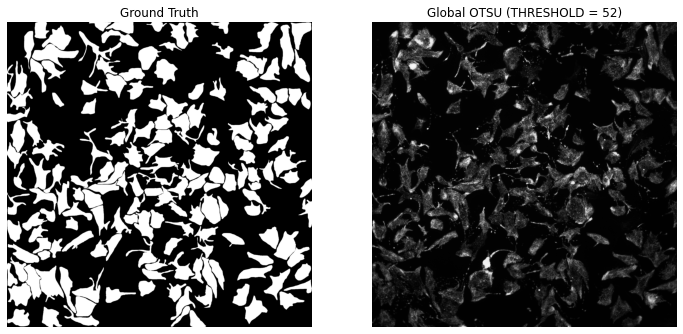

In [232]:
plot_comparison(image_true, image, 'Global OTSU (THRESHOLD = %d)' % threshold)

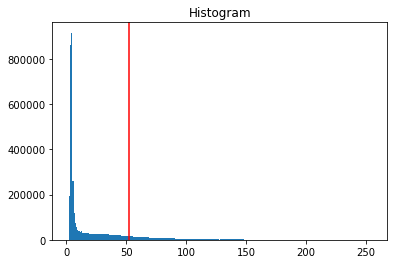

In [233]:
plt.hist(image.ravel(), bins=256)
plt.axvline(threshold, color = 'r')
plt.title("Histogram")
plt.show()

In [236]:
# Local OTSU thresholding
radius = [1,2,3,4,5,10,15,20,30]
local_otsu = []
for r in radius:
    footprint = disk(r)
    local_threshold = skimage.filters.rank.otsu(image, footprint)
    local_otsu.append(image >= local_threshold)

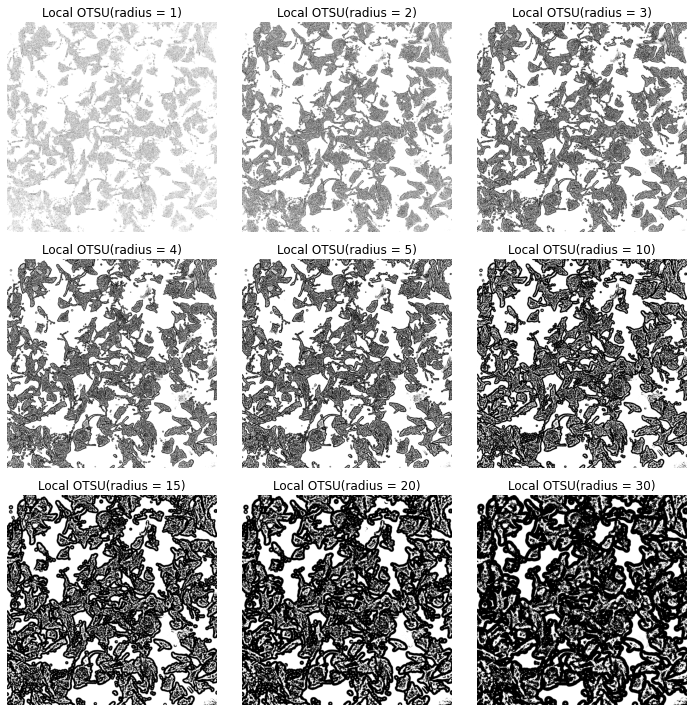

In [237]:
fig, axes = plt.subplots(3,3, figsize = (10,10))
ax = axes.ravel()

for i in range(len(radius)):
    ax[i].imshow(local_otsu[i], cmap = 'gray')
    ax[i].set_title("Local OTSU(radius = %d)"% radius[i])
    ax[i].axis("off")

plt.tight_layout()
plt.show()

#### Local OSTU method when radius is between 2 and 10 seems to perform well. 

### Watershed

In [6]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from skimage.morphology import (erosion, dilation, opening, closing)

In [170]:
# seeds = plt.imread("A - 10(fld 3 wv DAPI - DAPI).tif")
# image = plt.imread("A - 10(fld 3 wv TexasRed - TexasRed).tif")
# image_true = plt.imread("A - 10(fld 3 wv TexasRed - TexasRed)_mask.gif")
seeds = plt.imread("C - 12(fld 10 wv DAPI - DAPI).tif")
image = plt.imread("C - 12(fld 10 wv TexasRed - TexasRed).tif")
image_true = plt.imread("C - 12(fld 10 wv TexasRed - TexasRed)_mask.gif")
image = img_as_ubyte(image)
seeds = img_as_ubyte(seeds)

In [171]:
#Apply 3 times erosion to get rid of background particles
# n_opening = 30
# for x in range(n_opening):
#     image = opening(image)

n_erosion = 3
for x in range(n_erosion):
    image = erosion(image)
    seeds = erosion(seeds)

n_dilation = 3
for x in range(n_erosion):
    image = dilation(image)
    seeds = dilation(seeds)

In [172]:
# Global OTSU thresholding on image
threshold2 = skimage.filters.threshold_otsu(image)
image[np.where(image <= threshold2)] = 0 

# Global OTSU thresholding on seeds
threshold = skimage.filters.threshold_otsu(seeds)
seeds = (seeds >= threshold)

In [168]:
# Method 1. Find local peak by algorithm

D = ndi.distance_transform_edt(image)
localMax = peak_local_max(D, indices=False, min_distance=20, labels=image)
# Using 8-connectivity to appy the Watershed algorithm
markers = ndi.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=image)

/var/folders/0t/7448nlln6ng3qqb1hyl1t5rr0000gn/T/ipykernel_8337/507474049.py:4: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20, labels=image)


In [173]:
#Method 2. Using extracted seeds from data image

distance = ndi.distance_transform_edt(image)
markers, _ = ndi.label(seeds)
labels = watershed(-distance, markers, mask=image)

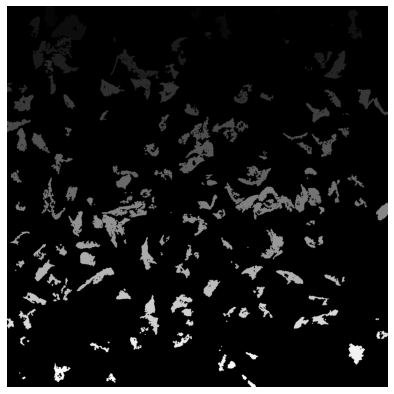

In [174]:
plt.subplots(figsize = (7,7))
plt.imshow(labels, cmap = "gray")
plt.axis('off')
plt.show()

In [162]:
# Local OTSU thresholding on image
# Method 1. Find local peak by algorithm
radius = [2,3,4,5,6,7,8,9,10]
local_labels = []
for r in radius:
    
    footprint = disk(r)
    local_threshold = skimage.filters.rank.otsu(image, footprint)
#     image_r = (image >= local_threshold) #<, <=, >,
    image_r = image
    image_r[np.where(image_r <= local_threshold)] = 0

    
    D = ndi.distance_transform_edt(image_r)
    localMax = peak_local_max(D, indices=False, min_distance=20, labels=image_r)
    # Using 8-connectivity to appy the Watershed algorithm
    markers = ndi.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=image_r)
    local_labels.append(labels)

/var/folders/0t/7448nlln6ng3qqb1hyl1t5rr0000gn/T/ipykernel_8337/598209063.py:15: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20, labels=image_r)


In [150]:
#Method 2. Using extracted seeds from data image
radius = [2,3,4,5,6,7,8,9,10]
local_labels = []
for r in radius:
    
    footprint = disk(r)
    local_threshold = skimage.filters.rank.otsu(image, footprint)
#     image_r = (image >= local_threshold) #<, <=, >,
    image_r = image
    image_r[np.where(image_r <= local_threshold)] = 0
    
    # Local OTSU thresholding on seeds
    local_threshold = skimage.filters.rank.otsu(seeds, footprint)
    seeds_r = (seeds >= local_threshold) #<, <=, >,
    
    distance = ndi.distance_transform_edt(image_r)
    markers, _ = ndi.label(seeds_r)
    labels = watershed(-distance, markers, mask=image_r)
    local_labels.append(labels)

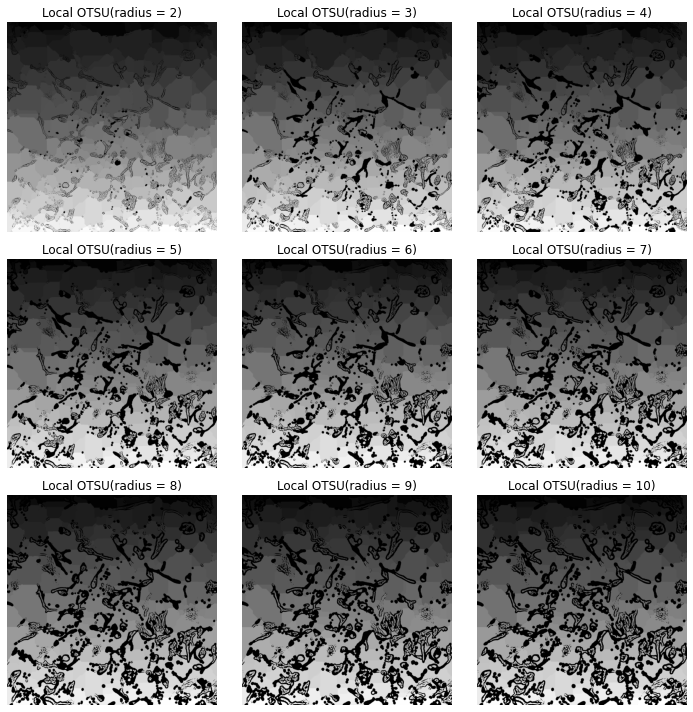

In [163]:
fig, axes = plt.subplots(3,3, figsize = (10,10))
ax = axes.ravel()

for i in range(len(radius)):
    ax[i].imshow(local_labels[i], cmap = 'gray')
    ax[i].set_title("Local OTSU(radius = %d)"% radius[i])
    ax[i].axis("off")

plt.tight_layout()
plt.show()

### Propagation

In [3]:
import heapq

In [248]:
# Data set 1
seeds = plt.imread("A - 10(fld 3 wv DAPI - DAPI).tif")
image = plt.imread("A - 10(fld 3 wv TexasRed - TexasRed).tif")
image_true = plt.imread("A - 10(fld 3 wv TexasRed - TexasRed)_mask.gif")

In [220]:
# Data set 2
seeds = plt.imread("C - 12(fld 10 wv DAPI - DAPI).tif")
image = plt.imread("C - 12(fld 10 wv TexasRed - TexasRed).tif")
image_true = plt.imread("C - 12(fld 10 wv TexasRed - TexasRed)_mask.gif")

In [249]:
#Apply 3 times erosion to get rid of background particles
n_erosion = 3
for x in range(n_erosion):
    image = erosion(image)
    #seeds = erosion(seeds)

n_dilation = 3
for x in range(n_erosion):
    image = dilation(image)
    #seeds = dilation(seeds)

    
n_erosion = 3
for x in range(n_erosion):
    #image = erosion(image)
    seeds = erosion(seeds)

n_dilation = 3
for x in range(n_erosion):
    #image = dilation(image)
    seeds = dilation(seeds)

# n_closing = 30
# for x in range(n_closing):
#     seeds = closing(seeds)

# n_opening = 30
# for x in range(n_opening):
#     seeds = opening(seeds)
    

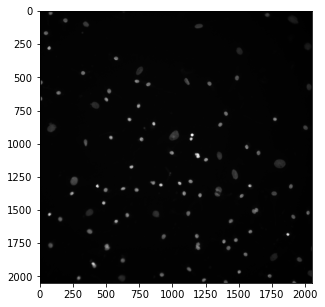

In [239]:
plt.subplots(figsize=(5,5))
plt.imshow(seeds, cmap = 'gray')

In [262]:
''''''
'Gaussian blur'
def g_blur(x, k = 3):
    x = cv2.GaussianBlur(x, (k,k), cv2.BORDER_DEFAULT)
    return x

In [250]:
image = g_blur(image)

In [251]:
image = img_as_ubyte(image)
seeds = img_as_ubyte(seeds)

In [252]:
# Global OTSU thresholding
threshold = skimage.filters.threshold_otsu(seeds)
seeds[np.where(seeds <= threshold)] = 0 #threshold  #<, <=, >,

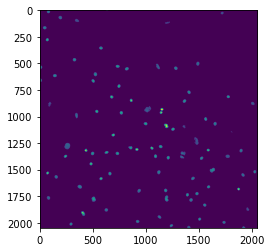

In [253]:
plt.imshow(seeds)

In [254]:
# Global OTSU thresholding
threshold2 = skimage.filters.threshold_otsu(image)
image[np.where(image <= threshold2)] = 0 #threshold  #<, <=, >,

In [255]:
# np.unique(seeds)

In [730]:
# def border(image, i, j):

#     if i < 0: i = 0
#     if i >= image.shape[1]: i = image.shape[1]-1
#     if j < 0: j = 0
#     if j >= image.shape[0]: j = image.shape[0]-1
    
#     return image[j, i] 

# def distance(image, j1, i1, j2, i2, lambda_0):
    

#     Eucli = (float(i1) - i2)**2 + (float(j1) - j2)**2
    
#     gradient_diff = 0.0
#     for delta_j in [-1,0,1]:
#         for delta_i in [-1,0,1]:
            
#             gradient_diff += math.fabs(float(border(image, i1 + delta_i, j1 + delta_j)) -
#                                    float(border(image, i2 + delta_i, j2 + delta_j)))
   

#     return math.sqrt((gradient_diff**2 + lambda_0 * Eucli)/ (lambda_0 + 1.0))

In [263]:
def distance(image, j1, i1, j2, i2, lambda_0):
    
    Eucli = (float(i1) - i2)**2 + (float(j1) - j2)**2
    
    gradient_diff = 0.0
    for delta_j in [-1,0,1]:
        for delta_i in [-1,0,1]:
            
            j1 = j1 + delta_j
            if j1 < 0: j1 = 0  
            if j1 >= image.shape[0]: j1 = image.shape[0]-1
                
            i1 = i1 + delta_i
            if i1 < 0: i1 = 0  
            if i1 >= image.shape[1]: i1 = image.shape[1]-1
                
            j2 = j2 + delta_j
            if j2 < 0: j2 = 0  
            if j2 >= image.shape[0]: j2 = image.shape[0]-1
                
            i2 = i2 + delta_i
            if i2 < 0: i2 = 0  
            if i2 >= image.shape[1]: i2 = image.shape[1]-1

            gradient_diff += math.fabs(float(image[j1, i1]) -
                                   float(image[j2, i2]))
            
            gradient_diff = math.sqrt(Eucli)*gradient_diff
   

    return math.sqrt((gradient_diff**2 + lambda_0 * Eucli)/ (lambda_0 + 1.0))

In [264]:

def propagate(image, image_seg, pq, dist, j, i, label_ji, lambda_0):

    if i > 0:
        if image_seg[j, i-1] == 0: #left
            dist = dist + distance(image, j, i, j, i-1, lambda_0)
            heapq.heappush(pq, (dist, j, i-1, label_ji))
    if j > 0:
        if image_seg[j-1, i] == 0: #up
            dist = dist + distance(image, j, i, j-1, i, lambda_0)
            heapq.heappush(pq, (dist, j-1, i, label_ji))
    if i < image.shape[1] -1:
        if image_seg[j, i+1] == 0: #right
            dist = dist + distance(image, j, i, j, i+1, lambda_0)
            heapq.heappush(pq, (dist, j, i+1, label_ji))
    if j < image.shape[0] -1:
        if image_seg[j+1, i] == 0: #down
            dist = dist + distance(image, j, i, j+1, i, lambda_0)
            heapq.heappush(pq, (dist, j+1, i, label_ji))
    if i > 0 and j > 0: 
        if image_seg[j-1, i-1] == 0: #left up
            dist = dist + distance(image, j, i, j-1, i-1, lambda_0)
            heapq.heappush(pq, (dist, j-1, i-1, label_ji))
    if i < image.shape[1] -1 and j > 0: 
        if image_seg[j-1, i+1] == 0: #right up
            dist = dist + distance(image, j, i, j-1, i+1, lambda_0)
            heapq.heappush(pq, (dist, j-1, i+1, label_ji))
    if i > 0 and j < image.shape[0]- 1:
        if image_seg[j+1, i-1] == 0: #left down
            dist = dist + distance(image, j, i, j+1, i-1, lambda_0)
            heapq.heappush(pq, (dist, j+1, i-1, label_ji))
    if i < image.shape[1] -1 and j < image.shape[0] -1:
        if image_seg[j+1, i+1] == 0: #right down
            dist = dist + distance(image, j, i, j+1, i+1, lambda_0)
            heapq.heappush(pq, (dist, j+1, i+1, label_ji))

In [258]:
n = image.shape[0]
m = image.shape[1]
# image n*m pixels
# Set up "Inf" distance and output labels for all pixels
dists = np.array(np.ones((n, m)) * math.inf)
image_seg = seeds.copy()

In [259]:
# Set up "seeds" pixels' distance as 0 and push their 8-connected neighbors for propagation
lambda_0 = 1e-10

# Dijkstra's algorithm
pq = []
for j in range(n):
    for i in range(m):
        label_ji = seeds[j,i]
        if label_ji > 0:
            dists[j,i] = 0.0
            propagate(image, image_seg, pq, 0.0,  j, i, label_ji, lambda_0)

In [260]:
while len(pq) > 0:
    dist, j, i, label = heapq.heappop(pq)
    if dists[j,i] > dist:
        dists[j,i] = dist
        image_seg[j,i] = label
        propagate(image, image_seg, pq, dist, j, i, label, lambda_0)

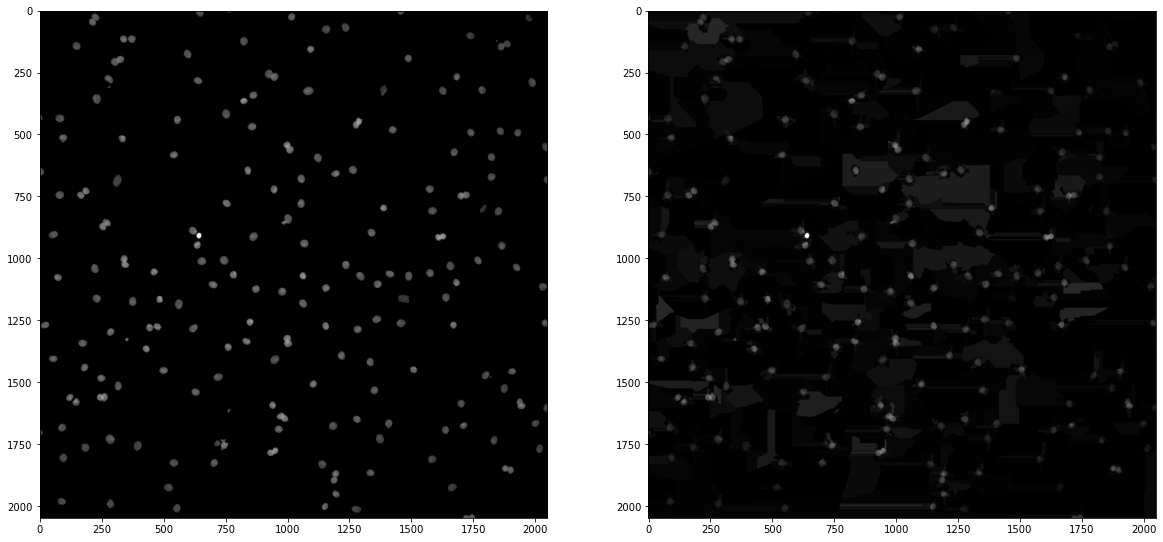

In [219]:
#2
#1e-1
fig = plt.subplots(figsize = (20,20))
plt.subplot(121)
plt.imshow(seeds, cmap = "gray")
plt.subplot(122)
plt.imshow(image_seg, cmap = "gray")

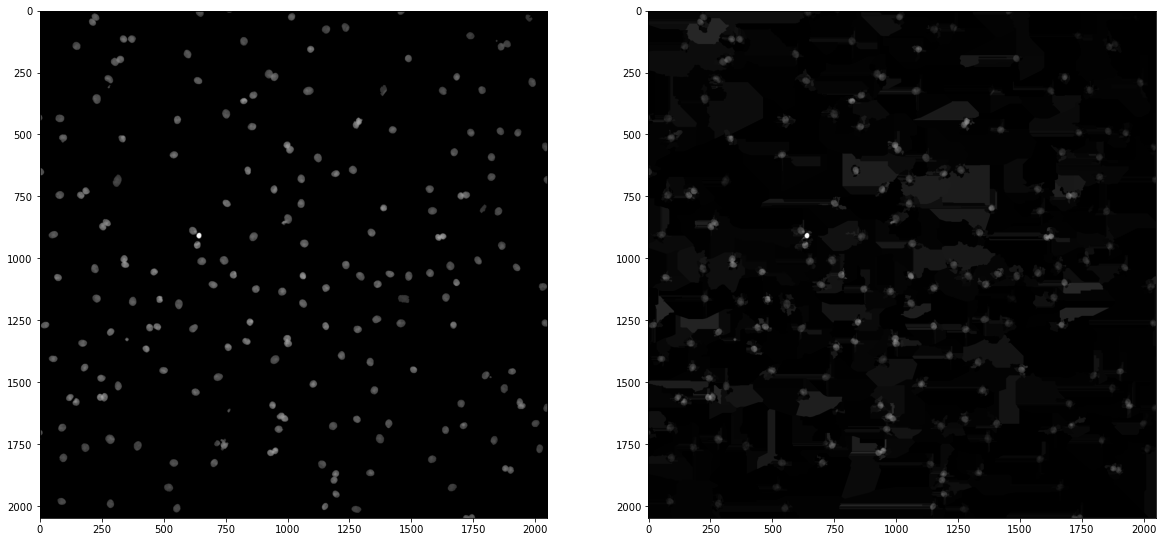

In [234]:
#2
#1e-10
fig = plt.subplots(figsize = (20,20))
plt.subplot(121)
plt.imshow(seeds, cmap = "gray")
plt.subplot(122)
plt.imshow(image_seg, cmap = "gray")

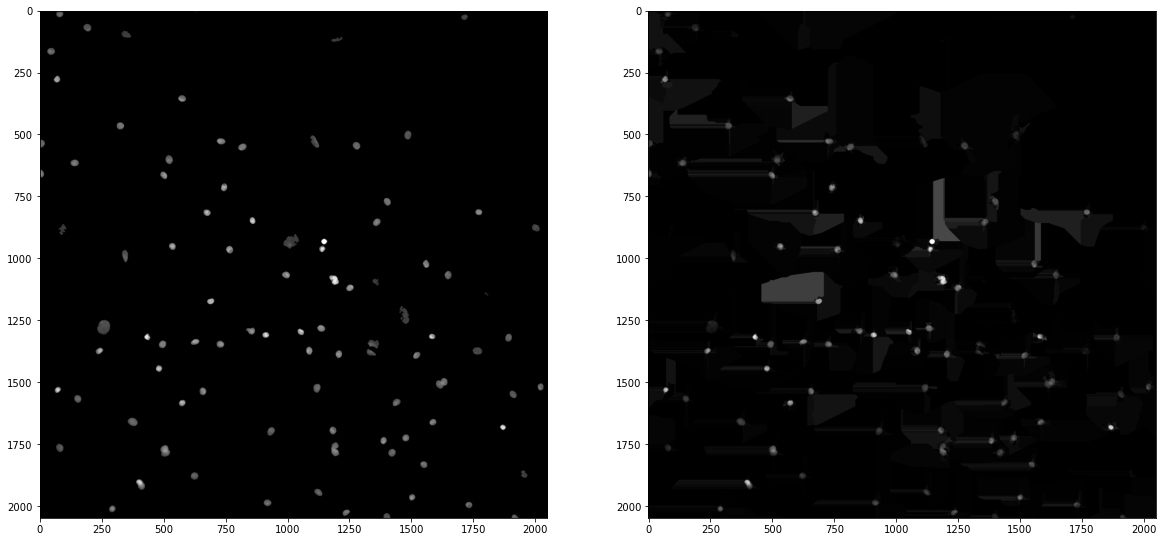

In [247]:
#1
#1e-1
fig = plt.subplots(figsize = (20,20))
plt.subplot(121)
plt.imshow(seeds, cmap = "gray")
plt.subplot(122)
plt.imshow(image_seg, cmap = "gray")

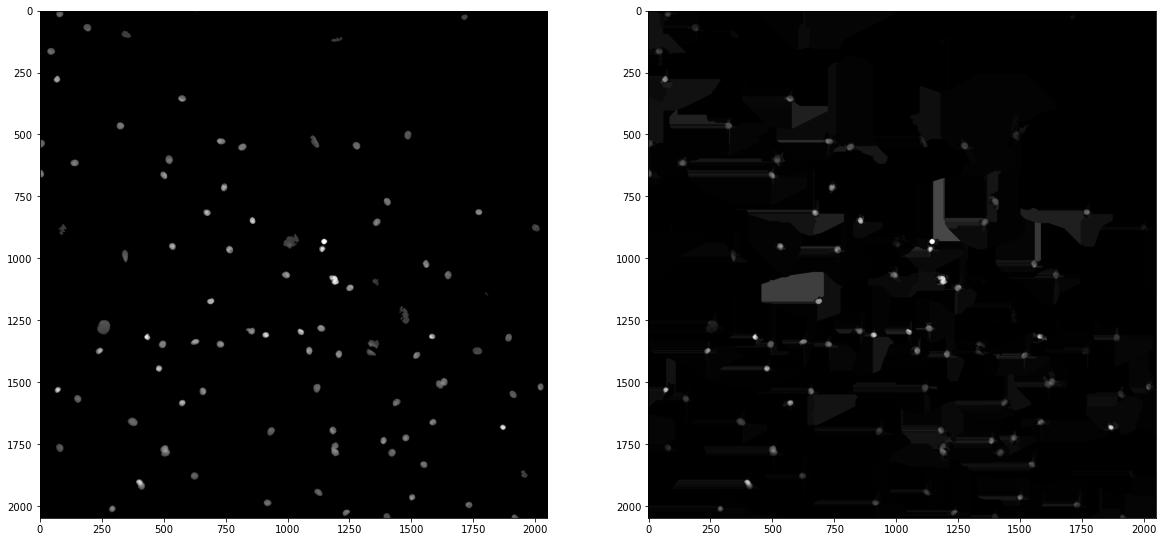

In [261]:
#1e-10
fig = plt.subplots(figsize = (20,20))
plt.subplot(121)
plt.imshow(seeds, cmap = "gray")
plt.subplot(122)
plt.imshow(image_seg, cmap = "gray")

### Evaluation on simulation data

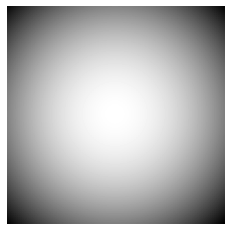

In [283]:
# image
n = 100
x = float((n/4)**2) - np.array((np.tile(np.arange(1, n+1, step = 1), n) - n/2)**2 
                        +(np.repeat(np.arange(1, n+1, step = 1), n) - n/2)**2).reshape(n,n)

image = (x - np.min(x)) / (np.max(x) - np.min(x))
plt.imshow(image, cmap = "gray")
plt.axis('off')
plt.show()

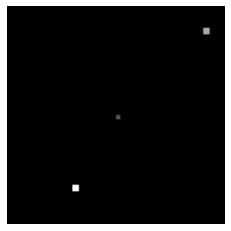

In [284]:
# seeds
seeds = np.zeros((n,n), dtype = int)
seeds[50:52, 50:52] = 1
seeds[10:13, 90:93] = 2
seeds[82:85, 30:33] = 3
plt.imshow(seeds, cmap = "gray")
plt.axis('off')
plt.show()

In [312]:
n = image.shape[0]
m = image.shape[1]
# image n*m pixels
# Set up "Inf" distance and output labels for all pixels
dists = np.array(np.ones((n, m)) * math.inf)
image_seg = seeds.copy()
# Set up "seeds" pixels' distance as 0 and push their 8-connected neighbors for propagation
lambda_0 = 1e-10

# Dijkstra's algorithm
pq = []
for j in range(n):
    for i in range(m):
        label_ji = seeds[j,i]
        if label_ji > 0:
            dists[j,i] = 0.0
            propagate(image, image_seg, pq, 0.0,  j, i, label_ji, lambda_0)

while len(pq) > 0:
    dist, j, i, label = heapq.heappop(pq)
    if dists[j,i] > dist:
        dists[j,i] = dist
        image_seg[j,i] = label
        propagate(image, image_seg, pq, dist, j, i, label, lambda_0)

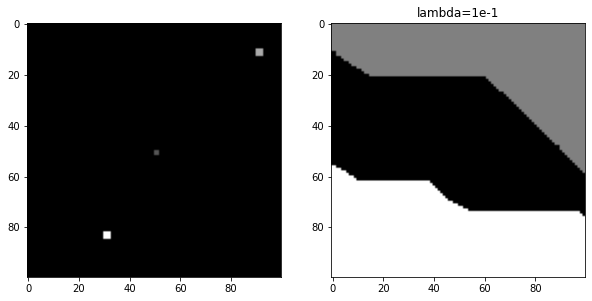

In [309]:
#1e-1
fig = plt.subplots(figsize = (10,10))
plt.subplot(121)
plt.imshow(seeds, cmap = "gray")
plt.subplot(122)
plt.imshow(image_seg, cmap = "gray")
plt.title("lambda=1e-1")
plt.show()

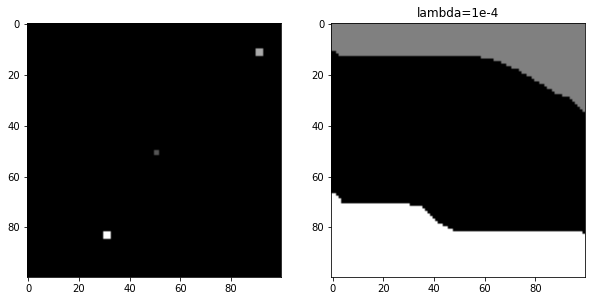

In [311]:
#1e-4
fig = plt.subplots(figsize = (10,10))
plt.subplot(121)
plt.imshow(seeds, cmap = "gray")
plt.subplot(122)
plt.imshow(image_seg, cmap = "gray")
plt.title("lambda=1e-4")
plt.show()

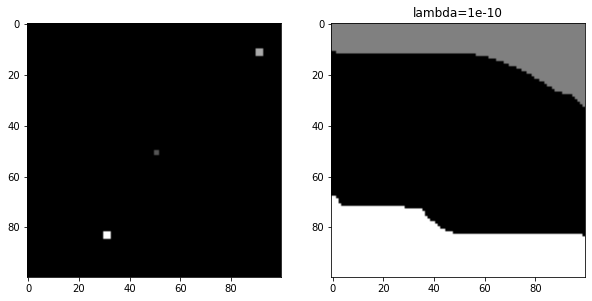

In [313]:
#1e-10
fig = plt.subplots(figsize = (10,10))
plt.subplot(121)
plt.imshow(seeds, cmap = "gray")
plt.subplot(122)
plt.imshow(image_seg, cmap = "gray")
plt.title("lambda=1e-10")
plt.show()

In [645]:

# def distance(sobelx, sobely, i1, j1, i2, j2, lambda_0):

#     d_Eucl = (i1 - i2)**2 + (j1 - j2)**2
#     d_G = ((i1 - i2)* sobelx[i1, j1] + (j1 - j2)* sobely[i1, j1])**2

#     return math.sqrt((d_G + lambda_0 * d_Eucl)/ (1.0 + lambda_0))

In [646]:
# def neighbors(pq, dist, sobelx, sobley, i, j, m, n, lambda_0, label_ij, labels):

#     if i > 0:
#         if labels[i-1, j] == 0:
#             dist = dist + distance(sobelx, sobely, i, j, i-1, j, lambda_0)
#             heapq.heappush(pq, (dist, i-1, j, label_ij))
#     if j > 0:
#         if labels[i, j-1] == 0:
#             dist = dist + distance(sobelx, sobely, i, j, i, j-1, lambda_0)
#             heapq.heappush(pq, (dist, i, j-1, label_ij))
#     if i < m -1:
#         if labels[i+1, j] == 0:
#             dist = dist + distance(sobelx, sobely, i, j, i+1, j, lambda_0)
#             heapq.heappush(pq, (dist, i+1, j, label_ij))
#     if j < n -1:
#         if labels[i, j+1] == 0:
#             dist = dist + distance(sobelx, sobely, i, j, i, j+1, lambda_0)
#             heapq.heappush(pq, (dist, i, j+1, label_ij))
#     if i > 0 and j > 0:
#         if labels[i-1, j-1] == 0:
#             dist = dist + distance(sobelx, sobely, i, j, i-1, j-1, lambda_0)
#             heapq.heappush(pq, (dist, i-1, j-1, label_ij))
#     if i < m -1 and j > 0:
#         if labels[i+1, j-1] == 0:
#             dist = dist + distance(sobelx, sobely, i, j, i+1, j-1, lambda_0)
#             heapq.heappush(pq, (dist, i+1, j-1, label_ij))
#     if i > 0 and j < n- 1:
#         if labels[i-1, j+1] == 0:
#             dist = dist + distance(sobelx, sobely, i, j, i-1, j+1, lambda_0)
#             heapq.heappush(pq, (dist, i-1, j+1, label_ij))
#     if i < m -1 and j < n -1:
#         if labels[i+1, j+1] == 0:
#             dist = dist + distance(sobelx, sobely, i, j, i+1, j+1, lambda_0)
#             heapq.heappush(pq, (dist, i+1, j+1, label_ij))

In [664]:
# m = image.shape[0]
# n = image.shape[1]
# # Set up "Inf" distance and output labels for all pixels
# # image m*n pixels
# dists = np.array(np.ones((m, n)) * math.inf)
# labels = seeds.copy()

In [665]:
# # lap = cv2.Laplacian(x,cv2.CV_64F,ksize=3) 
# # lap = np.uint8(np.absolute(lap))

# #### Gradient of the image 
# sobelx= cv2.Sobel(image,0, dx=1,dy=0,ksize=3)
# sobelx= np.uint8(np.absolute(sobelx))
 
# sobely= cv2.Sobel(image,0, dx=0,dy=1,ksize=3)
# sobely = np.uint8(np.absolute(sobely))

In [666]:
# # Set up "seeds" pixels' distance as 0 and push their 8-connected neighbors for propagation
# lambda_0 = 1e-9
# pq = []
# for j in range(n):
#     for i in range(m):
#         label_ij = labels[i,j]
#         if label_ij > 0:
#             dists[i,j] = 0.0
#             neighbors(pq, 0.0, sobelx, sobely, i, j, m, n, lambda_0, label_ij, labels)
            
# while len(pq) > 0:
#     dist, i, j, label = heapq.heappop(pq)
#     if dists[i,j] > dist:
#         dists[i,j] = dist
#         labels[i,j] = label
#         neighbors(pq, dist, sobelx, sobely, i, j, m, n, lambda_0, label, labels)

In [669]:
# fig = plt.subplots(figsize = (20,20))
# plt.subplot(121)
# plt.imshow(seeds, cmap = "gray")
# plt.subplot(122)
# plt.imshow(labels, cmap = "gray")